In [1]:
from betago.dataloader.goboard import GoBoard
from betago.processor import SevenPlaneProcessor
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import os
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import random
from tqdm import tqdm

In [23]:
with open('filtered_annotations.pkl', 'rb') as file:
    annotations = pkl.load(file)

### Go Model

In [5]:
from go_model import GoModel
go_model = GoModel(None)
checkpoint = torch.load('model_ckpt.pth.tar', map_location=torch.device('cuda'))
state_dict = checkpoint['state_dict']
state_dict = {key[7:]:state_dict[key] for key in state_dict} #remove 'module.' prefix
go_model.load_state_dict(state_dict)

class GoReprModel(nn.Module):
    
    def __init__(self, go_model):
        super(GoReprModel, self).__init__()
        self.convs = go_model.convs
        self.nonlinear = go_model.nonlinear
    
    def forward(self, x):
        for i in range(len(self.convs)):
            x = self.convs[i](x)
            x = self.nonlinear(x)
        return nn.Flatten()(x)
    
go_repr = GoReprModel(go_model)
go_repr = go_repr.cuda() 

### Keywords

In [6]:
keywords = ['territory', 'cut', 'sente', 'shape', 'moyo',
            'ko', 'invasion', 'influence', 'wall', 'eye',
            'black', 'white', 'to', 'me']

### Probe Model

In [15]:
linear_probe = nn.Linear(11552, len(keywords)).cuda() 

mlp_probe = nn.Sequential(
    nn.Linear(11552, 512),
    nn.ReLU(),
    nn.Linear(512, len(keywords))).cuda()

probe_model = linear_probe

### Training/Testing

In [16]:
annotations.sort(key = lambda ant : ant['f_name'])
train_ants = annotations[:int(len(annotations)*0.8)]
test_ants = annotations[int(len(annotations)*0.8):]
train_dataset = SevenPlaneBoWDataset(train_ants, keywords)
test_dataset = SevenPlaneBoWDataset(test_ants, keywords)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
def train(epoch):
    probe_model.train()
    for step, (svp, label) in enumerate(tqdm(train_loader)):
        svp = svp.type(torch.FloatTensor).cuda()
        label = label.cuda()
        representation = go_repr(svp).detach()
        pred = probe_model(representation)  
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        logger.add_scalar('Loss/train', loss.data.item(), step + epoch*len(train_loader))
    
def evaluate(epoch):
    probe_model.eval()
    epoch_loss = 0
    for step, (svp, label) in enumerate(tqdm(test_loader)):
        svp = svp.type(torch.FloatTensor).cuda()
        label = label.cuda()
        representation = go_repr(svp).detach()
        pred = probe_model(representation)  
        loss = criterion(pred, label)
        epoch_loss += loss.data.item()
    logger.add_scalar('Loss/test', epoch_loss, epoch)
    return epoch_loss

def save_checkpoint(state, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(state, save_path)

In [18]:
exp_name = 'linear_probe'
num_epochs = 2
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(probe_model.parameters())
logger = SummaryWriter(os.path.join('exp_log', exp_name))
ckpt_dir = os.path.join('probe_ckpts', exp_name)

In [32]:
torch.from_numpy(np.ones(1)).cuda().detach().detach()

tensor([1.], device='cuda:0', dtype=torch.float64)

In [19]:
best_loss = 1e10
for epoch in range(num_epochs):
    train(epoch)
    loss = evaluate(epoch)
    print('[EVAL] epoch loss %f' % loss)
    if loss < best_loss:
        print('[EVAL] new best ckpt')
        best_loss = loss
        save_checkpoint({
            'epoch':epoch,
            'state_dict':probe_model.state_dict(),
            'optimizer':optimizer.state_dict()
            }, os.path.join(ckpt_dir, 'best.ckpt'))
    save_checkpoint({
        'epoch':epoch,
        'state_dict':probe_model.state_dict(),
        'optimizer':optimizer.state_dict()
        }, os.path.join(ckpt_dir, 'epoch%d.ckpt' % epoch))

  0%|                                                                                                                            | 0/2926 [00:00<?, ?it/s]

[EVAL] epoch loss 210.682509
[EVAL] new best ckpt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [02:02<00:00,  5.98it/s]

[EVAL] epoch loss 211.365305


In [11]:
best_ckpt = torch.load(os.path.join(ckpt_dir, 'best.ckpt'))
probe_model.load_state_dict(best_ckpt['state_dict'])

<All keys matched successfully>

### Probe Evaluation

In [20]:
pred_ls, label_ls = [], []
for svp, label in tqdm(test_loader):
    svp = svp.type(torch.FloatTensor).cuda()
    label = label.cuda()
    representation = go_repr(svp).detach()
    pred = probe_model(representation)  
    pred_ls.append(pred.detach().cpu().numpy())
    label_ls.append(label.detach().cpu().numpy())
preds = np.concatenate(pred_ls, axis=0)
labels = np.concatenate(label_ls, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [01:28<00:00,  8.27it/s]


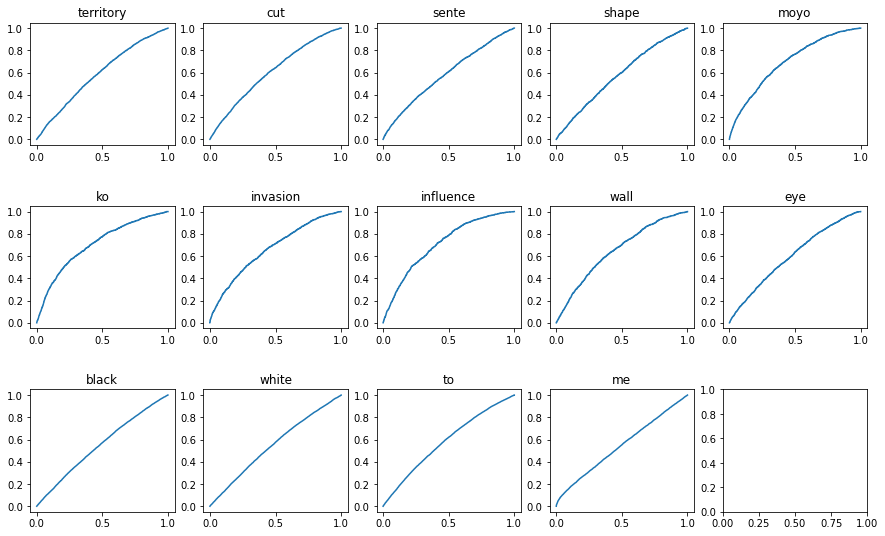

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from math import ceil

cols, rows = 5, ceil(len(keywords)/5)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    kw_preds, kw_labels = preds[:,kw], labels[:,kw]
    fprs, tprs, _ = roc_curve(kw_labels, kw_preds)
    axs[kw//cols][kw%cols].plot(fprs, tprs)
    axs[kw//cols][kw%cols].set_title(keywords[kw])